# Survival Analysis with Neural Networks
This notebook demonstrates a complete workflow for survival analysis using a custom multi-task neural network model. The notebook covers data preparation, model definition, training, and evaluation.

# Data Preparation

## installing the necessary libraries.

In [ ]:
!pip install scikit-learn==1.0.2
!pip install scikit-survival

  Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.1
    Uninstalling scikit-learn-1.5.1:
      Successfully uninstalled scikit-learn-1.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.15.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.0.2 which is incompatible.
scikit-survival 0.23.0 requires scikit-learn<1.6,>=1.4.0, but you have scikit-learn 1.0.2 which is incompatible.


  Using cached scikit_learn-1.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached scikit_learn-1.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.4 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: Operation cancelled by user


In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam


## Loading the dataset from an Excel file and performing necessary preprocessing

In [ ]:
# data = pd.read_excel('4A_TB_cleaned.xlsx')
data = pd.read_csv('/content/TB_Analysis.csv')
data.head(20)

,UNIT,IP NUMBER,SEX,AGE,RELIGION,DISTRICT OF RESIDENCE,WORKING DIAGNOSIS,OUT COME,NUMBER OF PREVIOUS ADMISSIONS,TB_type,MARITAL STATUS,MONTH OF ADMISSION,DAY OF ADMISSION,YEAR OF ADMISSION,DURATION,REGION,ADDITIONAL WORKING DIAGNOSIS,NUMBER OF ADDITIONAL WORKING DIAGNOSIS
0,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,2,November,Tuesday,2010,6,CENTRAL,"ISS,,",1
1,GI,1868011,F,46,COU,Kampala,"ISS Stage I&II,Disseminated TB,,",IMPROVED,3,Disseminated TB,2,December,Monday,2010,4,CENTRAL,"ISS Stage I&II,,",1
2,GI,1868840,M,80,ISLAM,Wakiso,"myeloproliferat,Malaria,INTESTINAL TB,",IMPROVED,7,Abdominal_TB,4,December,Wednesday,2010,8,CENTRAL,"myeloproliferat,Malaria,",2
3,GI,1851080,M,22,CATHOLIC,KAMPALA,"Abd TB,,,",IMPROVED,8,Abdominal_TB,9,December,Monday,2010,9,CENTRAL,",,",0
4,GI,1870478,F,18,COU,KAMPALA,"PTB,,,",IMPROVED,4,PTB,1,January,Thursday,2011,5,CENTRAL,",,",0
5,GI,1870374,F,24,CATHOLIC,KAMPALA,"MILIARY PTB,ORALCANDIDIASIS,,",DIED,2,Disseminated TB,9,January,Wednesday,2011,3,CENTRAL,"ORALCANDIDIASIS,,",1
6,GI,1870081,F,18,CATHOLIC,KAMPALA,"MENINGOENCEPHAL,LIVER CIRRHOSIS,POSSIBLE PTB,",DIED,4,PTB,1,January,Sunday,2011,5,CENTRAL,"MENINGOENCEPHAL,LIVER CIRRHOSIS,",2
7,GI,1874168,M,57,COU,KAMPALA,"ISS,ABDOMINAL TB,PERIPHERAL NEUR,",IMPROVED,6,Abdominal_TB,4,January,Thursday,2011,7,CENTRAL,"ISS,PERIPHERAL NEUR,",2
8,IDF,1874996,F,30,CATHOLIC,WAKISO,"Abd TB,ORALCANDIDIASIS,ISS,",IMPROVED,8,Abdominal_TB,2,January,Friday,2011,9,CENTRAL,"ORALCANDIDIASIS,ISS,",2
9,GI,1899527,M,37,CATHOLIC,KAMPALA,"HEPATITIS VIRAL,GASTROENTERITIS,PUD,ABD TB",DIED,5,Abdominal_TB,9,February,Monday,2011,6,CENTRAL,"HEPATITIS VIRAL,GASTROENTERITIS,PUD",3


In [ ]:
# prompt: in the data, each row is duplicated to have four similar rows in the data. I want to remain with a single row out of those four. even the index was rest. But they similar rows are following each other

# data = data[::4]
# data.reset_index(drop=True, inplace=True)
# data.head(20)


,UNIT,IP NUMBER,SEX,AGE,RELIGION,DISTRICT OF RESIDENCE,WORKING DIAGNOSIS,OUT COME,NUMBER OF PREVIOUS ADMISSIONS,TB_type,MARITAL STATUS,MONTH OF ADMISSION,DAY OF ADMISSION,YEAR OF ADMISSION,DURATION,REGION,ADDITIONAL WORKING DIAGNOSIS,NUMBER OF ADDITIONAL WORKING DIAGNOSIS
0,GI,1861416,M,30,COU,Nakasongola,"ISS,Abdominal TB,,",IMPROVED,5,Abdominal_TB,2,November,Tuesday,2010,6,CENTRAL,"ISS,,",1
1,GI,1868011,F,46,COU,Kampala,"ISS Stage I&II,Disseminated TB,,",IMPROVED,3,Disseminated TB,2,December,Monday,2010,4,CENTRAL,"ISS Stage I&II,,",1
2,GI,1868840,M,80,ISLAM,Wakiso,"myeloproliferat,Malaria,INTESTINAL TB,",IMPROVED,7,Abdominal_TB,4,December,Wednesday,2010,8,CENTRAL,"myeloproliferat,Malaria,",2
3,GI,1851080,M,22,CATHOLIC,KAMPALA,"Abd TB,,,",IMPROVED,8,Abdominal_TB,9,December,Monday,2010,9,CENTRAL,",,",0
4,GI,1870478,F,18,COU,KAMPALA,"PTB,,,",IMPROVED,4,PTB,1,January,Thursday,2011,5,CENTRAL,",,",0
5,GI,1870374,F,24,CATHOLIC,KAMPALA,"MILIARY PTB,ORALCANDIDIASIS,,",DIED,2,Disseminated TB,9,January,Wednesday,2011,3,CENTRAL,"ORALCANDIDIASIS,,",1
6,GI,1870081,F,18,CATHOLIC,KAMPALA,"MENINGOENCEPHAL,LIVER CIRRHOSIS,POSSIBLE PTB,",DIED,4,PTB,1,January,Sunday,2011,5,CENTRAL,"MENINGOENCEPHAL,LIVER CIRRHOSIS,",2
7,GI,1874168,M,57,COU,KAMPALA,"ISS,ABDOMINAL TB,PERIPHERAL NEUR,",IMPROVED,6,Abdominal_TB,4,January,Thursday,2011,7,CENTRAL,"ISS,PERIPHERAL NEUR,",2
8,IDF,1874996,F,30,CATHOLIC,WAKISO,"Abd TB,ORALCANDIDIASIS,ISS,",IMPROVED,8,Abdominal_TB,2,January,Friday,2011,9,CENTRAL,"ORALCANDIDIASIS,ISS,",2
9,GI,1899527,M,37,CATHOLIC,KAMPALA,"HEPATITIS VIRAL,GASTROENTERITIS,PUD,ABD TB",DIED,5,Abdominal_TB,9,February,Monday,2011,6,CENTRAL,"HEPATITIS VIRAL,GASTROENTERITIS,PUD",3


In [ ]:
data.shape

(4092, 18)

In [ ]:



# function to calculate the survival status
def calculate_survival_status(row):
    if row['OUT COME'] == 'DIED':
        return 1
    else:
        return 0


data['SURVIVAL'] = data.apply(calculate_survival_status, axis=1)

data.drop(columns=['UNIT','DISTRICT OF RESIDENCE','WORKING DIAGNOSIS','ADDITIONAL WORKING DIAGNOSIS',
                   'MARITAL STATUS', 'IP NUMBER', 'OUT COME'], inplace=True)

new_col_order = ['SEX', 'AGE', 'RELIGION', 'REGION', 'NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'TB_type',
                 'NUMBER OF PREVIOUS ADMISSIONS', 'DAY OF ADMISSION', 'MONTH OF ADMISSION',
                 'YEAR OF ADMISSION', 'DURATION', 'SURVIVAL']
data = data[new_col_order]

data.dropna(subset=['SURVIVAL'], inplace=True)
data.reset_index(drop=True, inplace=True)
data['SURVIVAL'] = data['SURVIVAL'].astype(int)

data.shape

(16368, 12)

In [ ]:
data.head(20)

,SEX,AGE,RELIGION,REGION,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,TB_type,NUMBER OF PREVIOUS ADMISSIONS,DAY OF ADMISSION,MONTH OF ADMISSION,YEAR OF ADMISSION,DURATION,SURVIVAL
0,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
1,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
2,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
3,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
4,F,46,COU,CENTRAL,1,Disseminated TB,3,Monday,December,2010,4,0
5,F,46,COU,CENTRAL,1,Disseminated TB,3,Monday,December,2010,4,0
6,F,46,COU,CENTRAL,1,Disseminated TB,3,Monday,December,2010,4,0
7,F,46,COU,CENTRAL,1,Disseminated TB,3,Monday,December,2010,4,0
8,M,80,ISLAM,CENTRAL,2,Abdominal_TB,7,Wednesday,December,2010,8,0
9,M,80,ISLAM,CENTRAL,2,Abdominal_TB,7,Wednesday,December,2010,8,0


In [ ]:
data.isnull().sum()


,0
SEX,0
AGE,0
RELIGION,0
REGION,0
NUMBER OF ADDITIONAL WORKING DIAGNOSIS,0
TB_type,0
NUMBER OF PREVIOUS ADMISSIONS,0
DAY OF ADMISSION,0
MONTH OF ADMISSION,0
YEAR OF ADMISSION,0


## Encoding Categorical Features and Standardizing Continuous Features

In [ ]:


# dictionary for month encoding
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# dictionary for day of week encoding
day_mapping = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday':76 }

data['Month of Admission'] = data['MONTH OF ADMISSION'].map(month_mapping)
data['Day of Admission'] = data['DAY OF ADMISSION'].map(day_mapping)

data.drop(columns=['MONTH OF ADMISSION', 'DAY OF ADMISSION'], inplace=True)



categorical_features = ['SEX', 'RELIGION', 'REGION', 'TB_type']

dataset = pd.get_dummies(data, columns=categorical_features)
dataset = dataset.astype(int)
dataset.head()

#Standardizing continuous features
# standardize_features = ['AGE','NUMBER OF PREVIOUS ADMISSIONS','NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'DURATION', 'Month of Admission', 'Day of Admission']
# scaler = StandardScaler()
# dataset[standardize_features] = scaler.fit_transform(dataset[standardize_features])
# dataset.head()

,AGE,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,NUMBER OF PREVIOUS ADMISSIONS,YEAR OF ADMISSION,DURATION,SURVIVAL,Month of Admission,Day of Admission,SEX_F,SEX_M,...,REGION_EASTERN,REGION_NORTHERN,REGION_UNKNOWN,REGION_WESTERN,TB_type_Abdominal_TB,TB_type_CNS_TB,TB_type_Disseminated TB,TB_type_Other TBs,TB_type_PTB,TB_type_TB iris
0,30,1,5,2010,6,0,11,3,0,1,...,0,0,0,0,1,0,0,0,0,0
1,30,1,5,2010,6,0,11,3,0,1,...,0,0,0,0,1,0,0,0,0,0
2,30,1,5,2010,6,0,11,3,0,1,...,0,0,0,0,1,0,0,0,0,0
3,30,1,5,2010,6,0,11,3,0,1,...,0,0,0,0,1,0,0,0,0,0
4,46,1,3,2010,4,0,12,2,1,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:

dataset['SURVIVAL'].value_counts()


,count
SURVIVAL,
0,11124
1,5244


In [ ]:
dataset.to_csv('TB_Analysis.csv', index=False)

## Splitting Data and Converting Data to TensorFlow Dataset


In [ ]:

dataset['YEAR OF ADMISSION'].value_counts()

test_data = dataset[dataset['YEAR OF ADMISSION'] >= 2018].copy()
train_data = dataset[dataset['YEAR OF ADMISSION'] < 2018].copy()

test_data.drop(columns=['YEAR OF ADMISSION'], inplace=True)
train_data.drop(columns=['YEAR OF ADMISSION'], inplace=True)
dataset.drop(columns=['YEAR OF ADMISSION'], inplace=True)


def to_tf_dataset(data, features, target, task_col, batch_size=64):
    def generator():
        for _, row in data.iterrows():
            x = row[features].values.astype(np.float32)
            y = row[target].astype(np.float32)
            task = row[task_col].astype(np.int32) - 1
            yield x, y, task

    output_signature = (
        tf.TensorSpec(shape=(len(features),), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).batch(batch_size).shuffle(buffer_size=1024)

X = [col for col in dataset.columns if col not in ['SURVIVAL', 'WEEK', 'DURATION']]
E = 'SURVIVAL'
T = 'DURATION'

train_dataset = to_tf_dataset(train_data, X, E, T)
test_dataset = to_tf_dataset(test_data, X, E, T)

In [ ]:
train_data.shape

(13068, 25)

In [ ]:
test_data.shape

(3300, 25)

# **Model Training**

## Define the Multi-Task Model
A BaseMultiTaskModel class for our survival analysis is difined.

***Proposed model***

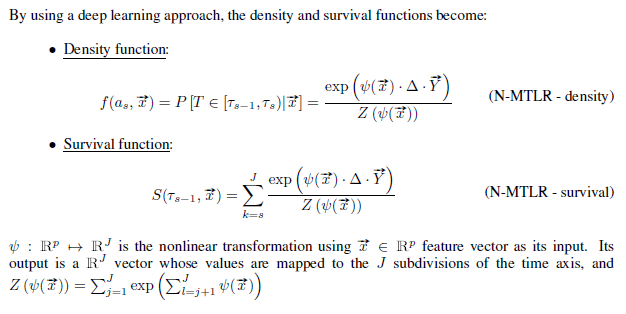





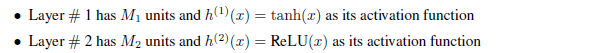


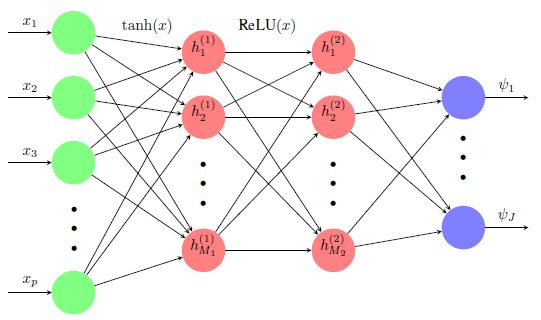

In [ ]:


class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True, dropout_rate=0.5, l2_lambda=0.01, initializer='glorot_uniform'):
        """
        Initialize the multi-task model.

        Parameters:
        structure (list): List of dictionaries specifying the structure of the neural network.
        bins (int): Number of bins for the time buckets.
        auto_scaler (bool): Whether to automatically scale the features.
        dropout_rate (float): Dropout rate for the layers.
        l2_lambda (float): L2 regularization lambda.
        initializer (str): Initializer for the layers.
        """
        self.structure = structure
        self.bins = bins
        self.auto_scaler = auto_scaler
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []
        self.val_loss_values = []
        self.initializer = initializer


    def get_initializer(self):
        """
        Get the initializer based on the specified type.

        Returns:
        tf.keras.initializers.Initializer: The initializer.
        """
        if self.initializer == 'glorot_uniform':
            return GlorotUniform()
        elif self.initializer == 'glorot_normal':
            return GlorotNormal()
        else:
            raise ValueError("Initializer not supported. Choose either 'glorot_uniform' or 'glorot_normal'.")


    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        """
        Generate the time buckets based on the provided times.

        Parameters:
        T (np.ndarray): Array of times.
        is_min_time_zero (bool): Whether to consider the minimum time as zero.
        extra_pct_time (float): Extra percentage of time to consider for the time buckets.
        """
        max_time = np.max(T)
        min_time = 0. if is_min_time_zero else np.min(T)
        p = extra_pct_time if 0. <= extra_pct_time <= 1. else 0.1

        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.time_buckets = [(self.times[i], self.times[i + 1]) for i in range(len(self.times) - 1)]
        self.num_times = len(self.time_buckets)


    def compute_XY(self, X, T, E, is_min_time_zero, extra_pct_time):
        """
        Compute the X and Y matrices for the censored and uncensored data.

        Parameters:
        X (np.ndarray): Feature matrix.
        T (np.ndarray): Array of times.
        E (np.ndarray): Array of event indicators.
        is_min_time_zero (bool): Whether to consider the minimum time as zero.
        extra_pct_time (float): Extra percentage of time to consider for the time buckets.

        Returns:
        tuple: X_cens, X_uncens, Y_cens, Y_uncens
        """
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]

        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            min_abs_value = [abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets]
            index = np.argmin(min_abs_value)

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[index:] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        return np.array(X_cens), np.array(X_uncens), np.array(Y_cens), np.array(Y_uncens)

    def build_model(self, input_shape):
        """
        Build the neural network model.

        Parameters:
        input_dim (int): Dimension of the input features.

        Returns:
        tf.keras.Model: The compiled model.
        """
        initializer = self.get_initializer()

        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'],
                      kernel_regularizer=l2(self.l2_lambda),
                      kernel_initializer=initializer)(x)
            x = Dropout(self.dropout_rate)(x)
        outputs = Dense(self.num_times + 1, activation='sigmoid', kernel_initializer=initializer)(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-5, clipnorm=1.0), loss=self.loss_function)
        return model


    def loss_function(self, y_true, y_pred):
        """
        Custom loss function for the model.

        Parameters:
        y_true (tf.Tensor): True labels.
        y_pred (tf.Tensor): Predicted labels.

        Returns:
        tf.Tensor: Loss value.
        """
        Triangle = np.tri(self.num_times + 1, self.num_times + 1, dtype=np.float32)
        Triangle = tf.convert_to_tensor(Triangle, dtype=tf.float32)

        phi_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))

        reduc_phi_uncens = tf.reduce_sum(phi_uncens * y_true, axis=1)

        z_uncens = tf.exp(tf.linalg.matmul(y_pred, Triangle))
        reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

        loss = -tf.reduce_sum(tf.math.log(reduc_phi_uncens)) + tf.reduce_sum(tf.math.log(reduc_z_uncens))
        return loss


    def fit(self, X, T, E, epochs=1000, batch_size=32, validation_split=0.2, verbose=True):
        """
        Fit the model to the data.

        Parameters:
        X (np.ndarray): Feature matrix.
        T (np.ndarray): Array of times.
        E (np.ndarray): Array of event indicators.
        is_min_time_zero (bool): Whether to consider the minimum time as zero.
        extra_pct_time (float): Extra percentage of time to consider for the time buckets.
        epochs (int): Number of epochs to train.
        batch_size (int): Batch size for training.
        validation_split (float): Fraction of the data to use for validation.
        """
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        self.model = self.build_model(self.num_vars)

        X_train = np.concatenate((X_cens, X_uncens), axis=0)
        Y_train = np.concatenate((Y_cens, Y_uncens), axis=0)

        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_split, random_state=42)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early_stopping])

        self.loss_values = history.history['loss']
        self.val_loss_values = history.history['val_loss']

    def predict(self, x):
        """
        Predict the survival probabilities for the given data.

        Parameters:
        X (np.ndarray): Feature matrix.

        Returns:
        np.ndarray: Predicted probabilities.
        """
        if self.auto_scaler:
            x = self.scaler.transform(x)

        x = np.array(x)
        score = self.model.predict(x)

        Triangle1 = np.tri(self.num_times + 1, self.num_times + 1)
        Triangle2 = np.tri(self.num_times + 1, self.num_times + 1)

        phi = np.exp(np.dot(score, Triangle1))
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = phi / div
        Survival = np.dot(density, Triangle2)
        hazard = density[:, :-1] / Survival[:, 1:]



        return hazard, density, Survival


    def predict_risk(self, x, use_log=False):
        """
        Predict the risk for the given data.

        Parameters:
        x (np.ndarray): Feature matrix.
        use_log (bool): Whether to return the log of the risk.

        Returns:
        np.ndarray: Predicted risk.
        """
        _, _, Survival = self.predict(x)
        risk = 1 - Survival[:, -1]
        return np.log(risk) if use_log else risk

    def plot_loss_curve(self):
        """
        Plot the loss curve.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Training Loss', color='blue')
        plt.plot(self.val_loss_values, label='Validation Loss', color='red')
        plt.title('Loss Function Values')
        plt.xlabel('Number of epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()


    def evaluate(self, X, T, E):
        """
        Evaluate the model using the concordance index.

        Parameters:
        X (np.ndarray): Feature matrix.
        T (np.ndarray): Array of times.
        E (np.ndarray): Array of event indicators.

        Returns:
        float: Concordance index.
        """
        X, T, E = np.array(X), np.array(T), np.array(E)
        if self.auto_scaler:
            X = self.scaler.transform(X)

        _, _, Survival = self.predict(X)

        events = Surv.from_arrays(E == 1, T)
        c_index = concordance_index_censored(E, T, -Survival[:, -1])[0]

        # Calculate the Brier score
        time_grid = np.linspace(0, T.max(), 100)
        brier_scores = []
        for t in time_grid:
            pred_risk = np.mean(Survival[:, :-1] >= t, axis=1)
            brier_score = np.mean((E - pred_risk) ** 2)
            brier_scores.append(brier_score)
        integrated_brier_score = np.trapz(brier_scores, time_grid) / T.max()

        self.plot_brier_score(time_grid, brier_scores, integrated_brier_score)
        self.plot_actual_vs_predicted(T, E, Survival)

        return c_index, integrated_brier_score

    def plot_brier_score(self, time_grid, brier_scores, integrated_brier_score):
        """
        Plot the Brier score curve.

        Parameters:
        time_grid (np.ndarray): Time grid.
        brier_scores (np.ndarray): Brier scores.
        integrated_brier_score (float): Integrated Brier score.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, brier_scores, label=f'IBS: {integrated_brier_score:.2f}', color='blue')
        plt.axhline(y=0.25, color='red', linestyle='--', label='0.25 limit')
        plt.title('Prediction Error Curve with Integrated Brier Score')
        plt.xlabel('Time')
        plt.ylabel('Brier Score')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_actual_vs_predicted(self, T, E, Survival):
        """
        Plot the actual vs. predicted number of events over time.

        Parameters:
        T (np.ndarray): Array of times.
        E (np.ndarray): Array of event indicators.
        Survival (np.ndarray): Survival probabilities.
        """
        time_grid = np.linspace(0, T.max(), 100)
        actual_events = np.array([(T >= t).sum() for t in time_grid])
        predicted_events = np.array([(Survival[:, :-1] >= t).sum() for t in time_grid])

        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, actual_events, label='Actual', color='red')
        plt.plot(time_grid, predicted_events, label='Predicted', color='blue')
        plt.fill_between(time_grid, predicted_events - 1.96 * np.sqrt(predicted_events),
                         predicted_events + 1.96 * np.sqrt(predicted_events), color='blue', alpha=0.2,
                         label='Confidence Intervals')
        plt.title('Actual vs Predicted Number of Events Over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Events')
        plt.legend()
        plt.grid(True)
        plt.show()



## Fitting and evaluating the model
The model structure is defined. The model is fitted on on our dataset and then evaluated

In [ ]:
structure = [{'activation': 'tanh', 'num_units': 64}, {'activation': 'relu', 'num_units': 64}]
model = BaseMultiTaskModel(structure=structure, bins=4)

# Fit the model
model.fit(train_data[X], train_data[T], train_data[E], epochs=300, batch_size=32, verbose=True, validation_split=0.2)




Epoch 1/300
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 9.6054 - val_loss: 9.2772
Epoch 2/300
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.2414 - val_loss: 9.1353
Epoch 3/300
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.0768 - val_loss: 8.9982
Epoch 4/300
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.1881 - val_loss: 8.8649
Epoch 5/300
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.0847 - val_loss: 8.7361
Epoch 6/300
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.9435 - val_loss: 8.6095
Epoch 7/300
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.8168 - val_loss: 8.4864
Epoch 8/300
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.5535 - val_loss: 8.3691
Epoch 9/300
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.5523 - val_loss: 8.2564
Epoch 10/300
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.4855 - val_loss: 8.1466
Epoch 11/300
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.2005 - val_loss: 8.0417
Epoch 12/300
327/327 ━━━━━━━━━━━━━━━━━━━━

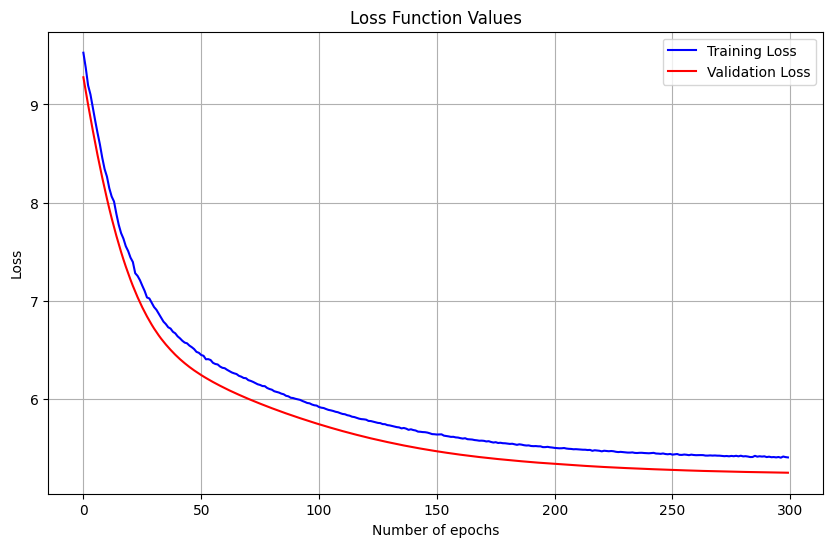

In [ ]:
 # Plot the loss curve
model.plot_loss_curve()

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


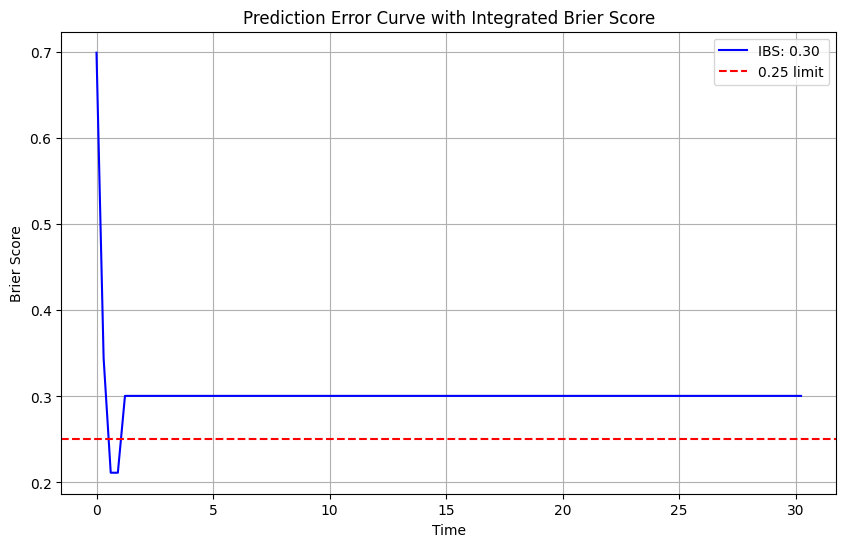

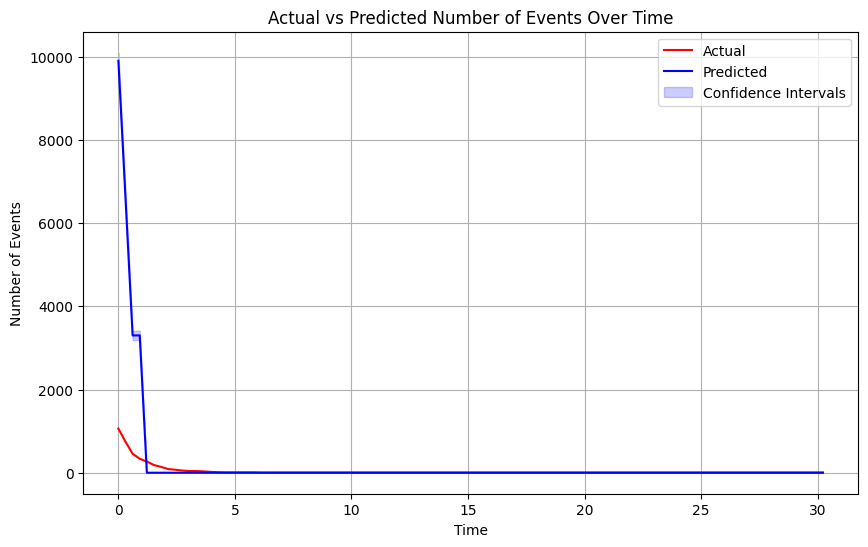

c-index: 0.4722108285479902, Brier score: 0.3012570145903479


In [ ]:
# Evaluate the model
c_index, brier_score = model.evaluate(test_data[X], test_data[T], test_data['SURVIVAL'] == 1) # Access the 'SURVIVAL' column and create a boolean array
print(f"c-index: {c_index}, Brier score: {brier_score}")

In [ ]:
# Make predictions (example)
hazard, density, Survival = model.predict(test_data[X].values[:5])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [ ]:
print(density)

[[0.64384836 0.23690505 0.08717263 0.03207396]
 [0.64384836 0.23690505 0.08717263 0.03207396]
 [0.64384836 0.23690505 0.08717263 0.03207396]
 [0.64384836 0.23690505 0.08717263 0.03207396]
 [0.64385834 0.23690158 0.08716841 0.03207166]]


In [ ]:
print(Survival)

[[1.         0.35615164 0.11924659 0.03207396]
 [1.         0.35615164 0.11924659 0.03207396]
 [1.         0.35615164 0.11924659 0.03207396]
 [1.         0.35615164 0.11924659 0.03207396]
 [1.         0.35614166 0.11924008 0.03207166]]
